In [24]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import matplotlib.gridspec as gs

In [25]:
from utility_fn import train_test_split , model_score
from normalize import log_norm 
#from utility_fn import trial_krn

In [26]:
en = np.linspace(0.3, 7.0 , 128)
data = np.loadtxt('data/data_spectrum.csv')
params = np.loadtxt('data/params_spectrum.csv')
print(data.shape)
print(params.shape)
data = log_norm(data)
data_noisy = data + 0.5*np.random.normal(size = data.shape)

(10000, 128)
(10000, 2)


In [27]:
(x_train,y_train) , (x_test,y_test) = train_test_split(data , params , 0.2)
x_train_noisy = x_train+0.4*np.random.normal(size=x_train.shape)
x_test_noisy = x_test+0.4*np.random.normal(size=x_test.shape)

In [28]:
enc_inputs = keras.Input(shape=(128 , ))
x = layers.Dense(64 , activation='relu')(enc_inputs)
x = layers.Dense(64, activation='relu')(x)
enc_outputs = layers.Dense(256, activation='relu')(x)

x = layers.Dense(64 , activation='relu')(enc_outputs)
x =  layers.Dense(64 , activation='relu')(x)
x = layers.Dense(128)(x)
dec_outputs = layers.LeakyReLU(alpha = 0.7)(x)
encoder = keras.Model(inputs=enc_inputs , outputs=enc_outputs , name = 'encoder')
#encoder.summary()
den_ae = keras.Model(inputs=enc_inputs , outputs=dec_outputs , name = 'autoencoder')
den_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               

In [29]:
den_ae.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [30]:
den_ae.fit(x_train_noisy , x_train , validation_split=0.3 , epochs = 30)

Epoch 1/30
175/175 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0037
Epoch 2/30
175/175 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/30
175/175 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 4/30
175/175 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 5/30
175/175 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/30
175/175 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 7/30
175/175 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/30
175/175 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 9/30
175/175 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/30
175/175 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0027

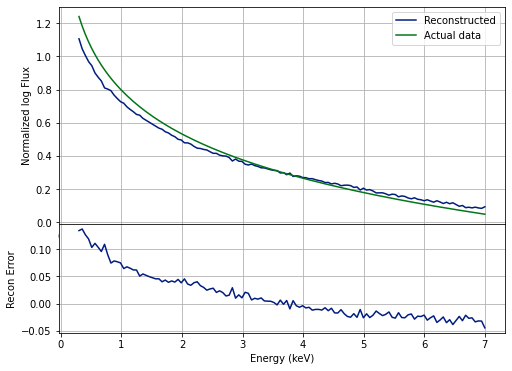

In [47]:
x_recon = den_ae.predict(x_test[10:11])
reco_error = x_test[10:11]-x_recon

fig = plt.figure(figsize=(8,6) )
spec = gs.GridSpec(nrows=2,ncols=1, figure=fig ,  height_ratios=[2,1] , hspace=0)
acc = fig.add_subplot(spec[0,0])
plt.grid(True)
acc.plot(en ,x_recon[0])
acc.plot(en , x_test[10:11][0])
acc.legend(['Reconstructed' , 'Actual data'])
acc.set_ylabel('Normalized log Flux')
loss = fig.add_subplot(spec[1,0], sharex = acc)
loss.plot(en , reco_error[0])
loss.set_xlabel('Energy (keV)')
loss.set_ylabel('Recon Error')
plt.grid(True)
plt.show()

## Quantitative Model Score

In [58]:
from sklearn.metrics import mean_squared_error

In [72]:
def recon_score(recon_model , bad_data , good_data):
    '''
    returns reconstruction error for a given model
    '''
    recon_data = recon_model.predict(bad_data)
    recon_error = mean_squared_error(good_data , recon_data)
    return recon_error
def pred_error(reg_model , data , params):
    '''
    returns parameter prediction error 
    for the given data set
    '''
    y_pred = reg_model.predict(data)
    mse = mean_squared_error(params , y_pred)
    return mse 

### simulating missing data
remove points from two data bands and then 
try reconstruction

In [53]:
def simulate_missing_data(data):
    data_missing = []
    data_noise_filled = []
    for x in data:
        temp = np.copy(x)
        temp[20:40] = np.zeros(20)
        temp[80:100] = np.zeros(20)
        data_missing.append(temp)
        temp_g = np.copy(x)
        temp_g[20:40] = np.random.normal(0.0, 0.5 , 20)
        temp_g[80:100] = np.random.normal(0.0, 0.5 , 20)
        data_noise_filled.append(temp)
    data_missing = np.asarray(data_missing)
    data_noise_filled = np.asarray(data_noise_filled)
    return data_missing , data_noise_filled


In [70]:
reg_model = keras.models.load_model('fc_model')
reg_model.summary()

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_141 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_144 (Dense)            (None, 2)                 66        
Total params: 14,562
Trainable params: 14,562
Non-trainable params: 0
_________________________________________________________________


In [61]:
x_train_gap , x_train_filled = simulate_missing_data(x_train)
x_test_gap , x_test_filled = simulate_missing_data(x_test)

#### Reconstruction score on missing data

In [67]:
test_recon_err = recon_score(den_ae , x_test_missing , x_test)
train_recon_error = recon_score(den_ae , x_train_missing , x_train)

print('reconstruction error on test data: ', test_recon_err)
print('reconstruction error on train data:' , train_recon_error)

reconstruction error on test data:  0.019414155148952002
reconstruction error on train data: 0.01912204614211916


### Checking Regression Model performence

In [77]:
print(pred_error(reg_model , x_train , y_train))
print(pred_error(reg_model , x_test , y_test))
print(pred_error(reg_model , x_train_gap , y_train))
print(pred_error(reg_model , x_test_gap , y_test))
print(pred_error(reg_model , x_train_filled , y_train))
print(pred_error(reg_model , x_test_filled , y_test))

0.00022723625170663922
0.0002642758619968026
3.248421582813513
3.1860986567947784
3.248421582813513
3.1860986567947784


## Reconstruction of Missing data

In [78]:
x_train_recon = den_ae.predict(x_train_missing)
print(pred_error(reg_model , x_train_recon , y_train))

0.19188404393542713


In [80]:
x_test_recon = den_ae.predict(x_test_missing)
print(pred_error(reg_model , x_test_recon , y_test))

0.18464769143670057
